In [2]:
#!pip install emoji
import pandas as pd
import numpy as np
import emoji
import regex
import random
import nltk
import re
import sklearn
import string
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples 
np.random.seed(10)
random.seed(10)
seed = 10

In [3]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Marti\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Marti\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
df = pd.read_csv('data2021.csv')
print(len(df))
df = df.drop_duplicates(subset=['user_id']) # remove duplicates

392446


In [5]:
df.dropna(subset=['user_description'], inplace=True) # remove NaN values

In [6]:
df['user_description']

1         Wiskunde lover, honden freak. 🇮🇱🇹🇭🏁🇩🇪🇭🇺🇳🇱🇷🇸🇸🇽🇸...
2         IT ICT IoT || •AgriFoodTech •Biobased •Circula...
6         Leesbaar, kroniek van gebeurtenissen in Amsterdam
7         Mijn #TOTELTUIN ++ #Noseflutejob ++ Bach on th...
8         Columnist https://t.co/eX0BHLeWH2. Boosdrietig...
                                ...                        
392401    Je suis un 🤖 veillant sur la qualité de l'air ...
392414    Voor het meest uitgebreide zakelijke nieuws be...
392416    Uitgeverij Historische Verhalen publiceert kor...
392422    Dutch,Jewish,single,had a great friend for lif...
392442     Gitarist (klassiek) 🎸🎼🎵🎶 en 🖥️🗃️🛠️ 😎 IT-Goeroe 😎
Name: user_description, Length: 92363, dtype: object

In [7]:
def give_emoji_free_text(text):
    """
    Description:
        Removes emojis from given text (biographies)
    Input:
        Text as string (biographies)
    Output:
        Text as string (emoji free biographies)
    Example:
        >>> give_emoji_free_text('Wiskunde lover, honden freak. 🇮🇱🇹🇭🏁🇩🇪🇭🇺🇳🇱🇷🇸🇸🇽🇸')
        'Wiskunde lover, honden freak.'
    """
    emoji_list = [c for c in text if c in emoji.EMOJI_DATA]
    clean_text = ' '.join([str for str in text.split() if not any(i in str for i in emoji_list)])
    return clean_text

def url_free_text(text):
    '''
    Description:
        Removes URLs from given text (biographies)
    Input:
        Text as string (biographies)
    Output:
        Text as string (URL free biographies)
    Example:
        >>> url_free_text('Columnist https://t.co/eX0BHLeWH2. Boosdrietig')
        'Columnist Boosdrietig'
    '''
    text = re.sub(r'http\S+', '', text)
    return text

In [8]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Apply the give_emoji_free_text function and get biographies free of emojis
call_emoji_free = lambda x: give_emoji_free_text(x)

wordnet_lemmatizer = WordNetLemmatizer()
def preprocessing(bio):
    '''
    Description:
        Preprocesses input text by: removing: punctuation, emojis, URLs, Dutch and English stopwords, \
        tokenisation, lowercasing and lemmatisation.
    Input:
        Text as string (biographies)
    Output:
        Text as list (preprocessed biographies)
    Example:
        >>> preprocessing('Wiskunde lover, honden freak. 🇮🇱🇹🇭🏁🇩🇪🇭🇺🇳🇱🇷🇸🇸🇽🇸')
        [wiskunde, lover, honden, freak]
    '''
    
    bio = "".join([i for i in bio if i not in (string.punctuation + '•')]) # Remove punctuation
    bio = call_emoji_free(bio) # Remove emojis
    bio = url_free_text(bio).rstrip() # Remove URLs
    bio = word_tokenize(bio, language="dutch") # Tokenise the biography
    
    bio = [item.lower() for item in bio] # lowercase
    
    stopwords = nltk.corpus.stopwords.words('dutch')
    bio = [i for i in bio if i not in stopwords] # Remove Dutch stopwords
    
    stopwords = nltk.corpus.stopwords.words('english')
    bio = [i for i in bio if i not in stopwords] # Remove English stopwords
    
    bio = [wordnet_lemmatizer.lemmatize(word) for word in bio] # Lemmatise the biographies
    
    return bio
    

In [9]:
df['preprocessed'] = df['user_description'].apply(preprocessing)

# Remove biographies which contain links only
df = df[df.astype(str)['preprocessed'] != '[]']

In [10]:
df['preprocessed']

1                          [wiskunde, lover, honden, freak]
2         [ict, iot, agrifoodtech, biobased, circular, d...
6            [leesbaar, kroniek, gebeurtenissen, amsterdam]
7         [toteltuin, noseflutejob, bach, sheepdogwhistl...
8         [columnist, boosdrietig, vanwege, tweet, jamme...
                                ...                        
392401    [suis, un, veillant, sur, la, qualité, lair, q...
392414    [meest, uitgebreide, zakelijke, nieuws, bezoek...
392416    [uitgeverij, historische, verhalen, publiceert...
392422    [dutchjewishsinglehad, great, friend, life, po...
392442                       [gitarist, klassiek, itgoeroe]
Name: preprocessed, Length: 90898, dtype: object

In [11]:
# Initialize CountVectorizer model and fit features
sentences_list =  df['preprocessed'].values
sentences = []
for i in sentences_list:
    detok = " ".join(i)
    sentences.append(detok)
vectorizer = CountVectorizer(max_df=0.80, min_df=0.005)
X = vectorizer.fit_transform(sentences)

In [12]:
X.shape

(90898, 159)

In [28]:
k = 51
for n_clusters in range(5, k, 5):


    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = MiniBatchKMeans(n_clusters=n_clusters, batch_size=3000, random_state=seed)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )



C:\Users\Marti\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 5 The average silhouette_score is : 0.2670093422443892


C:\Users\Marti\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 10 The average silhouette_score is : 0.24849618931556297


C:\Users\Marti\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 15 The average silhouette_score is : 0.21116504784569023


C:\Users\Marti\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 20 The average silhouette_score is : 0.198528570809617


C:\Users\Marti\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 25 The average silhouette_score is : 0.22750032109598614


C:\Users\Marti\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 30 The average silhouette_score is : 0.2224438333932794


C:\Users\Marti\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 35 The average silhouette_score is : 0.23219793085893223


C:\Users\Marti\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 40 The average silhouette_score is : 0.247723986413061


C:\Users\Marti\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 45 The average silhouette_score is : 0.2463083488914665


C:\Users\Marti\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 50 The average silhouette_score is : 0.2658617704860932


In [35]:
km = KMeans(n_clusters = 5, n_init = 10, random_state=seed) # Initialise the k-means clusterer
km = km.fit(X) # Compute k-means clustering

In [36]:
label = km.predict(X) # Compute cluster centers and predict cluster index for each sample

In [37]:
centers = (km.cluster_centers_)

In [38]:
# Calculate size of each cluster and group each by biography per cluster
cluster_dict = {}
freq_dict = {}
for count, value in enumerate(sentences):
    if label[count] in cluster_dict:
        freq_dict[label[count]] += 1
        cluster_dict[label[count]] += value
    else:
        freq_dict[label[count]] = 1
        cluster_dict[label[count]] = value

In [39]:
# Print 10 most frequent words per cluster and their size
from collections import Counter
cluster = {}
name_list = []

for i in cluster_dict:
    wordsList = str(cluster_dict[i]).split()
    wordsList = [ x for x in wordsList if x.isalpha() ]
    counters = Counter(wordsList)
    most_occur = counters.most_common(10)
    n_words = []
    for word in most_occur:
        n_words.append(word[0])
        
    name_list.append(n_words[0])
    print(n_words, "Cluster:", i, "Size:", freq_dict[i])
    cluster[i] = n_words[0]

['love', 'leven', 'life', 'fan', 'nederland', 'politiek', 'sport', 'music', 'moeder', 'jaar'] Cluster: 0 Size: 81954
['tweet', 'persoonlijke', 'eigen', 'titel', 'dutch', 'personal', 'english', 'naam', 'som', 'sm'] Cluster: 2 Size: 3444
['account', 'twitter', 'twitteraccount', 'gemeente', 'officiële', 'fan', 'volg', 'vragen', 'nederland', 'via'] Cluster: 3 Size: 1593
['nieuws', 'laatste', 'volg', 'tip', 'gemeente', 'politiek', 'sport', 'via', 'nederland', 'online'] Cluster: 1 Size: 2016
['vader', 'trotse', 'echtgenoot', 'getrouwd', 'opa', 'man', 'ondernemer', 'kinderen', 'dochters', 'twee'] Cluster: 4 Size: 1891


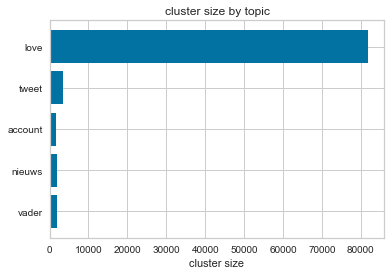

In [40]:
# Bar graph with named labels
cluster_size = list(freq_dict.values())
fig, ax = plt.subplots()

ax.barh(np.arange(len(name_list)), cluster_size, align='center')
ax.set_yticks(np.arange(len(name_list)), labels=name_list)
ax.invert_yaxis()
ax.set_xlabel('cluster size')
ax.set_title('cluster size by topic')

plt.show()